# Pendulum on $\sin (x)$.

## System definition

Consider a pendulum with mass $m_2$ hanging from a rod of length $l$. The support point has a mass $m_1$, and can move without friction along a  curve given by formula $y=f(x)$ 

![Pendulum](images/pendulum.png)

We will need some helpers for the algebra:

In [1]:
load("cas_utils.sage")

In [2]:
var('t')
var('l g m1 m2')
xy_wsp = [('x1','x_1'),('y1','y_1'),('x2','x_2'),('y2','y_2')]

uv_wsp = [('phi','\phi'),('x','x')]

to_fun, to_var = make_symbols(xy_wsp + uv_wsp)

uv = [vars()[v] for v,lv in uv_wsp]
xy = [vars()[v] for v,lv in xy_wsp]


x1  :: has been  processed
y1  :: has been  processed
x2  :: has been  processed
y2  :: has been  processed
phi  :: has been  processed
x  :: has been  processed


We introduce generalized coordinates compliant with contraints: $\varphi$, and $x$.

In [3]:
f(x) = sin(x)
x2u = {x1:x,x2:x+l*sin(phi),y2:-l*cos(phi)+sin(x),y1:f(x)} 
showmath(x2u)

<IPython.core.display.Math object>

We express virtual displacement:$\delta x_1,...$ as function of virtual displacements of new coordinates: $\delta x,\delta \phi.$

In [4]:
for w in xy:
    vars()['d'+repr(w)+'_polar']=sum([w.subs(x2u).diff(w2)*vars()['d'+repr(w2)] for w2 in uv])
    showmath([vars()['d'+repr(w)],vars()['d'+repr(w)+'_polar']])

Now we can write d'Alembert principle:

$$\sum_{i} ( \mathbf {F}_{i} - m_i \mathbf{a}_i )\cdot \delta \mathbf r_i = 0,$$


In [5]:
dAlemb = (m1*x1.subs(x2u).subs(to_fun).diff(t,2)  )*dx1_polar + \
         (m1*y1.subs(x2u).subs(to_fun).diff(t,2)+m1*g)*dy1_polar + \
         (m2*x2.subs(x2u).subs(to_fun).diff(t,2)  )*dx2_polar + \
         (m2*y2.subs(x2u).subs(to_fun).diff(t,2)+m2*g)*dy2_polar
dAlemb = dAlemb.subs(to_var)
showmath(dAlemb.collect(dx).collect(dphi))

<IPython.core.display.Math object>

and derive  equations of motion in new coordintes:

In [7]:
r1 = dAlemb.coefficient(dx)
r2 = dAlemb.coefficient(dphi)
w1,w2 =  solve([r1,r2],[xdd,phidd])[0] 
showmath(w1.trig_simplify())

<IPython.core.display.Math object>

In [8]:
showmath(w2)

<IPython.core.display.Math object>

#### Special case

$m_1\to\infty$, $x=-\frac{\pi}{2}$

In [9]:
showmath( limit(w1.rhs(),m1=oo).subs({xdd:0,xd:0,x:-pi/2})  )

<IPython.core.display.Math object>

In [10]:
showmath( limit(w2.rhs(),m1=oo).subs({xdd:0,xd:0,x:-pi/2}).trig_reduce() )

<IPython.core.display.Math object>

We obtain mathematical pendulum if

In [11]:
showmath( limit(w1.rhs(),m1=0).trig_reduce() )

<IPython.core.display.Math object>

In [12]:
showmath( limit(w2.rhs(),m1=0).trig_reduce() )

<IPython.core.display.Math object>

## Numerical analysis of the system
Initial conditions are four numbers: $x,\phi,\dot x,\dot \phi$. 


In [13]:
import numpy as np

In [14]:
%%time
pars = {l:1,g:9.81,m1:1.,m2:1}
ode = [xd,phid,w1.rhs().subs(pars),w2.rhs().subs(pars)]
times = srange(0,10.25,0.01)
ics = [1, 0, 0, 1]
sol = desolve_odeint(ode, ics, times, [x,phi,xd,phid])

CPU times: user 315 ms, sys: 19.7 ms, total: 334 ms
Wall time: 330 ms


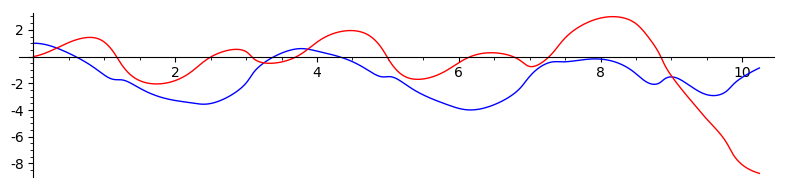

In [15]:
line( zip(times,sol[::1,0]),figsize=(8,2) )+\
 line( zip(times,sol[::1,1]),color='red')

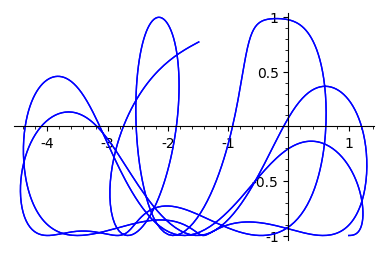

In [16]:
line( zip(times,sol[:,0]),figsize=4 )
line( zip(np.sin(sol[:,1])+sol[:,0],-np.cos(sol[:,1])),figsize=4 )+\
 line( zip(np.sin(sol[:,1])+sol[:,0],-np.cos(sol[:,1])),figsize=4 )

### Visualization

It is helpfull to write simple function displaying configuration of the system for given set of variables.

In [17]:
def draw_system(ith=0,l=1):
    x,phi = sol[ith,:2]
    x1,y1,x2,y2 =x, f(x),  l*sin(phi) + x,f(x)-l*cos(phi)
    
    p = point( (x1,y1), size=40) +\
     point( (x2,y2), size=40,color='red',figsize=3) +\
     line( [(x1,y1),(x2,y2)],aspect_ratio=1)
    n=40
    i0 = max(0,ith-n)
  
    trace = sum([point((l*sin(phi) + x,f(x)-l*cos(phi)),hue=(0,1-(i)/n,1)) for i,(x,phi) in enumerate(sol[ith:i0:-1,:2])])
    trace2 = sum([point((x,f(x)),hue=(.51,(i)/n,1)) for i,(x,phi) in enumerate(sol[i0:ith,:2])])
 
    p += trace+trace2
    var('x_')
    p += plot(f(x_),(x_,-4.5,1),figsize=6 ) 
    p.set_axes_range(-4.5,1,-2,1)
    p.set_aspect_ratio(1)
    return p

Let's try:

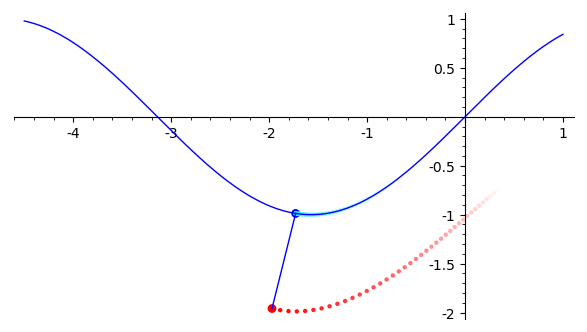

In [18]:
draw_system(120)

We can animate:

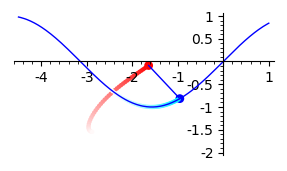

In [19]:
from IPython.display import clear_output
import time
for ith in range(0,len(sol),20):
    plt = draw_system(ith=ith,l=1)
    clear_output(wait=True)
    plt.show(figsize=3)
    time.sleep(0.021)


Alternatively one can use slider:

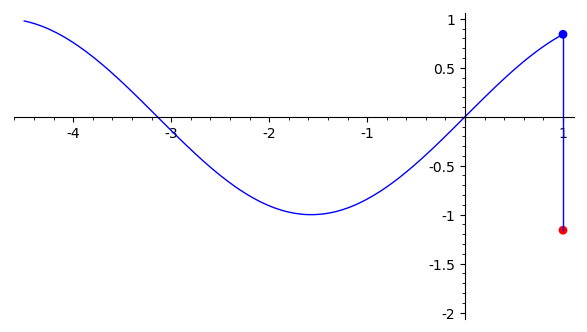

In [20]:
@interact
def _(ith=slider(range(len(sol)))):
    plt = draw_system(ith=ith,l=2)
    plt.show(figsize=6)  

### Chaotic properties of the solution

#### Spectrum

The solution looks chaotic, but it can be caused by mixing of few frequencies. We can, however, calculate the Fourier transform of one of the system variables and see.

In [21]:
%%time
pars = {l:1,g:9.81,m1:1.1,m2:1}
ode = [xd,phid,w1.rhs().subs(pars),w2.rhs().subs(pars)]
times = srange(0,5000.25,0.2)
ics = [1,0,0,0]
sol = desolve_odeint(ode,ics,times,[x,phi,xd,phid])
xfft = np.fft.fft(sol[:,0])
n1 = xfft.shape[0]

CPU times: user 9.28 s, sys: 1.62 s, total: 10.9 s
Wall time: 8.98 s


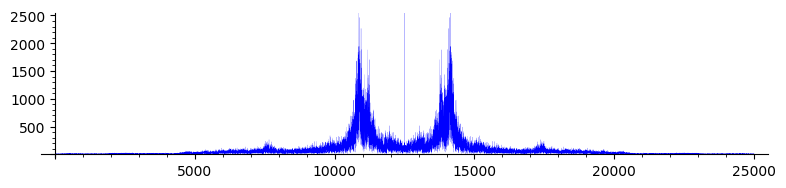

In [22]:
plt = line(enumerate(np.abs(np.fft.fftshift(xfft))),ymax=2500,thickness=0.1)
plt.show(figsize=(8,2))

Let us check for comparison that sum of two signals with different frequencies would not cause such effect

In [23]:
expr = sin(1.2*t)+sin(sqrt(1.2)*t)

In [24]:
import numpy as np
import sympy
expr_np = np.vectorize( sympy.lambdify(t, sympy.sympify( expr ) ) )

In [25]:
nonchaotic = expr_np(np.linspace(0,5000,10000))

In [26]:
%time nonchaotic_fft = np.fft.fft(nonchaotic)

CPU times: user 1.54 ms, sys: 101 µs, total: 1.64 ms
Wall time: 1.02 ms


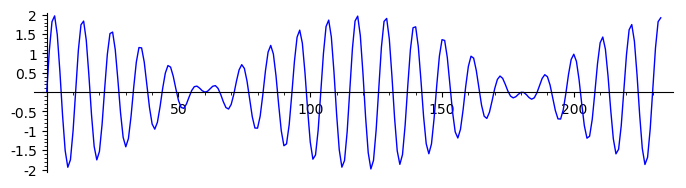

In [27]:
line(enumerate(nonchaotic[:234])).show(figsize=(7,2))

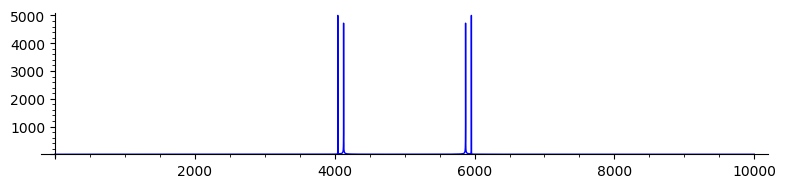

In [28]:
plt2 = line(enumerate(np.abs(np.fft.fftshift(nonchaotic_fft))),alpha=1)
plt2.show(figsize=(8,2))

#### Sensitivity to initial conditions

Let us compare two solution which differ by $\frac{1}{1000000}$ in initial velocity.

In [29]:
%%time
pars = {l:1,g:9.81,m1:1.1,m2:1}
ode = [xd,phid,w1.rhs().subs(pars),w2.rhs().subs(pars)]
times = srange(0,35.,0.1)
ics = [1,0,0,0]
sol = desolve_odeint(ode,ics,times,[x,phi,xd,phid])
ics2 = [1+1e-6,0,0,0]
sol2 = desolve_odeint(ode,ics2,times,[x,phi,xd,phid])


CPU times: user 159 ms, sys: 12.3 ms, total: 171 ms
Wall time: 144 ms


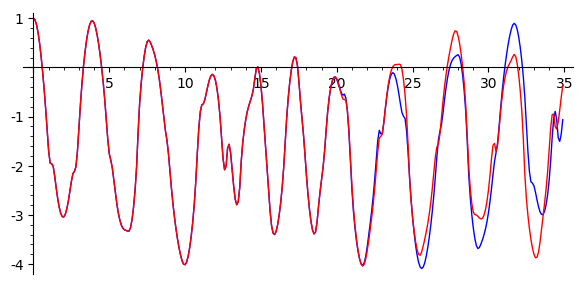

In [30]:
line(zip(times,sol[:,0]))+line(zip(times,sol2[:,0]),color='red',figsize=(6,3))

We can have a look how the error propagetes in log-scale:

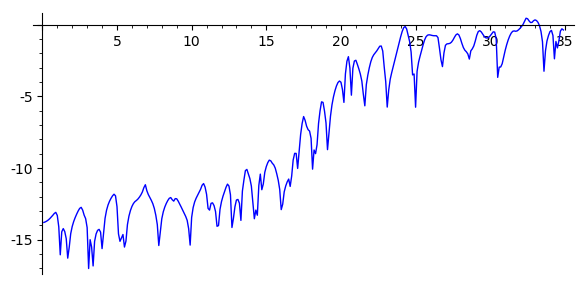

In [31]:
line(zip(times[1:],log(abs(sol[1:,0]-sol2[1:,0]))),figsize=(6,3)) 

\newpage